### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Import Transaction Logs Data

In [2]:
# Import transaction log, identify & set header, omit customer source data, set order_date as datetime dtype
df = pd.read_csv("data/transaction-log-example.csv", 
                 header=0, 
                 delimiter=",", 
                 usecols=['cust_id','order_date', 'net_sales'], 
                 parse_dates=['order_date'],
                 index_col=['order_date'])
df.head()

,cust_id,net_sales
order_date,,
2018-02-16,cust16647,108.784
2018-03-28,cust17852,117.000
2018-09-27,cust17852,315.900
2019-03-08,cust17852,159.250
2016-05-18,cust588,298.350


In [3]:
df_mkt = pd.read_csv("data/mktg-spend-example.csv", 
                 header=0, 
                 delimiter=",", 
                 usecols=['month','total_marketing_spend'], 
                 parse_dates=['month'],
                 index_col=['month'])

df_mkt.head()

,total_marketing_spend
month,
2016-01-01,648.653944
2016-02-01,988.526343
2016-03-01,928.085792
2016-04-01,685.889176
2016-05-01,1724.866225


### Context

- **Customer centricity**: need to measure and manage customer value
- CLV is important, but it requires a **statistical model** 
- Valuable to have **auditable performance measures**
- We can use raw transaction log that consists of customer ID, transaction date, and net sales to compute and evaluate KPIs.
- In addition to the transaction log, we need to use marketing spend data to compute margin performance.
- We will use a real transaction log:
  - Real high-growth “bricks and clicks” startup
  - $’s scaled, dates shifted

#### Key Performance Indicators (KPIs)

Calculate “from scratch”: 
1. Monthly sales over time
2. Total customers acquired 
3. Customer acquisition cost (CAC)
4. Distribution of spend per purchase
5. Initial versus repeat sales volume
6. Initial versus repeat average order value (AOV)
7. Sales and AOV by source
8. First-purchase profitability
9. Cohorted sales (the “C3”)
10. Revenue retention curves
11. Cumulative spend per customer
12. Distribution of total spend by customer
13. Customer concentration (“Pareto”) chart 

What they summarize: 
1. Growth
2. Unit costs
3. Unit profitability (unit economic performance)
4. Retention
5. Heterogeneity (customers, time)

### Analysis

#### 1. Total monthly sales

- **What**: total sales across all customers each month
- **Why**: most standard, commonly-used growth metric to demonstrate past performance and expected future performance
- **How**: group and aggregate (sum) net sales by year and month

**Analysis**: Data shows seasonality with relatively higher sales from October through December as compared to the rest of the year. Data also shows sales are rising year-on-year. Time series decomposition analysis below demonstrates the rising trend and seasonality in the data.

In [4]:
sales = df.groupby([(df.index.year), (df.index.month)])['net_sales'].sum()
sales.unstack()

order_date,1,2,3,4,5,6,7,8,9,10,11,12
order_date,,,,,,,,,,,,
2016,21395.010,31661.305,38094.407,24398.595,36170.030,83308.498,81053.024,111414.979,119505.412,161253.287,223141.646,243675.627
2017,124408.180,132210.728,195413.972,202013.188,237466.827,241425.470,222988.766,234852.293,284023.233,411017.581,548646.332,757308.032
2018,307756.319,316357.886,376486.838,429182.598,555779.198,542620.845,563051.736,614858.790,693434.443,738637.185,733041.049,1013547.405
2019,510834.298,560820.260,691195.674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(0.0, 1300000.0)

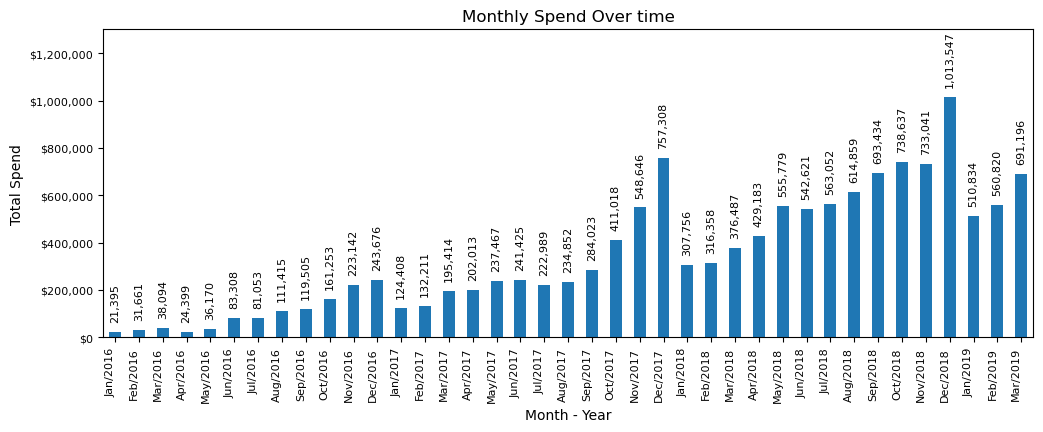

In [5]:
from matplotlib.ticker import FuncFormatter

ax = sales.plot(kind='bar',  
            figsize=(12,4),
            title="Monthly Spend Over time",
            xlabel='Month - Year',
            ylabel='Total Spend',
            fontsize=8)

ax.set_xticklabels([f'{pd.Timestamp(year=y, month=m, day=1):%b/%Y}' for y, m in sales.index], 
                   rotation=90, 
                   ha='right')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:,.0f}'))

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+50000, f'{y[i]:,.0f}', ha='center', rotation ='vertical', snap=True, size=8)
        
addlabels(sales.index, sales.values)

ax.set_ylim(0, 1_300_000)

##### Time Series Decomposition

**Breaking Down the Components in Time Series Decomposition**:
When a time series is decomposed, it is often represented as:
$$\text{Observed Data} = \text{Trend} + \text{Seasonality} + \text{Remainder (Residual/Error)}$$
Each component has a role:
- **Trend Component**: Captures the long-term progression or direction in the data (upward, downward, or stable trend over time).
- **Seasonal Component**: Captures the repeating, cyclical patterns that occur at regular intervals (e.g., monthly or quarterly patterns).
- **Remainder Component**: Captures the random noise, unexpected variations, and irregular fluctuations that are not explained by trend or seasonality.

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(sales, model='additive', period=12)

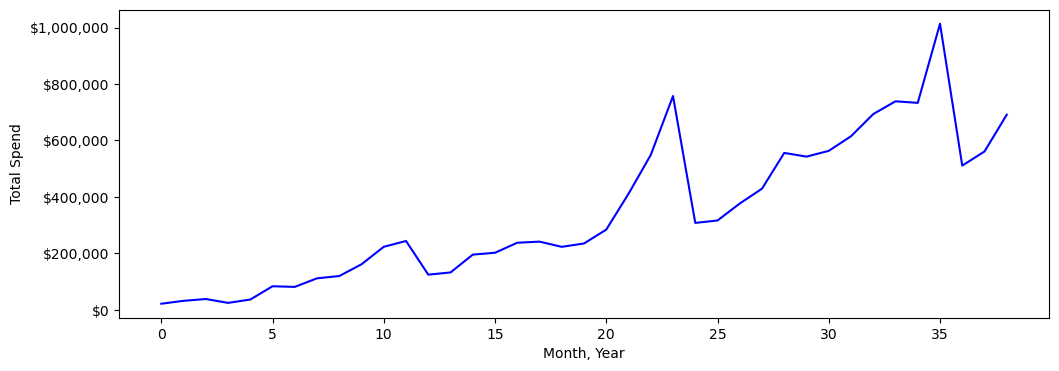

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12,4))
ax.plot(sales.values, color='b')
ax.set_xlabel('Month, Year')
ax.set_ylabel('Total Spend')
ax.yaxis.set_major_formatter(FuncFormatter(FuncFormatter(lambda y, _: f'${y:,.0f}')))
plt.show()

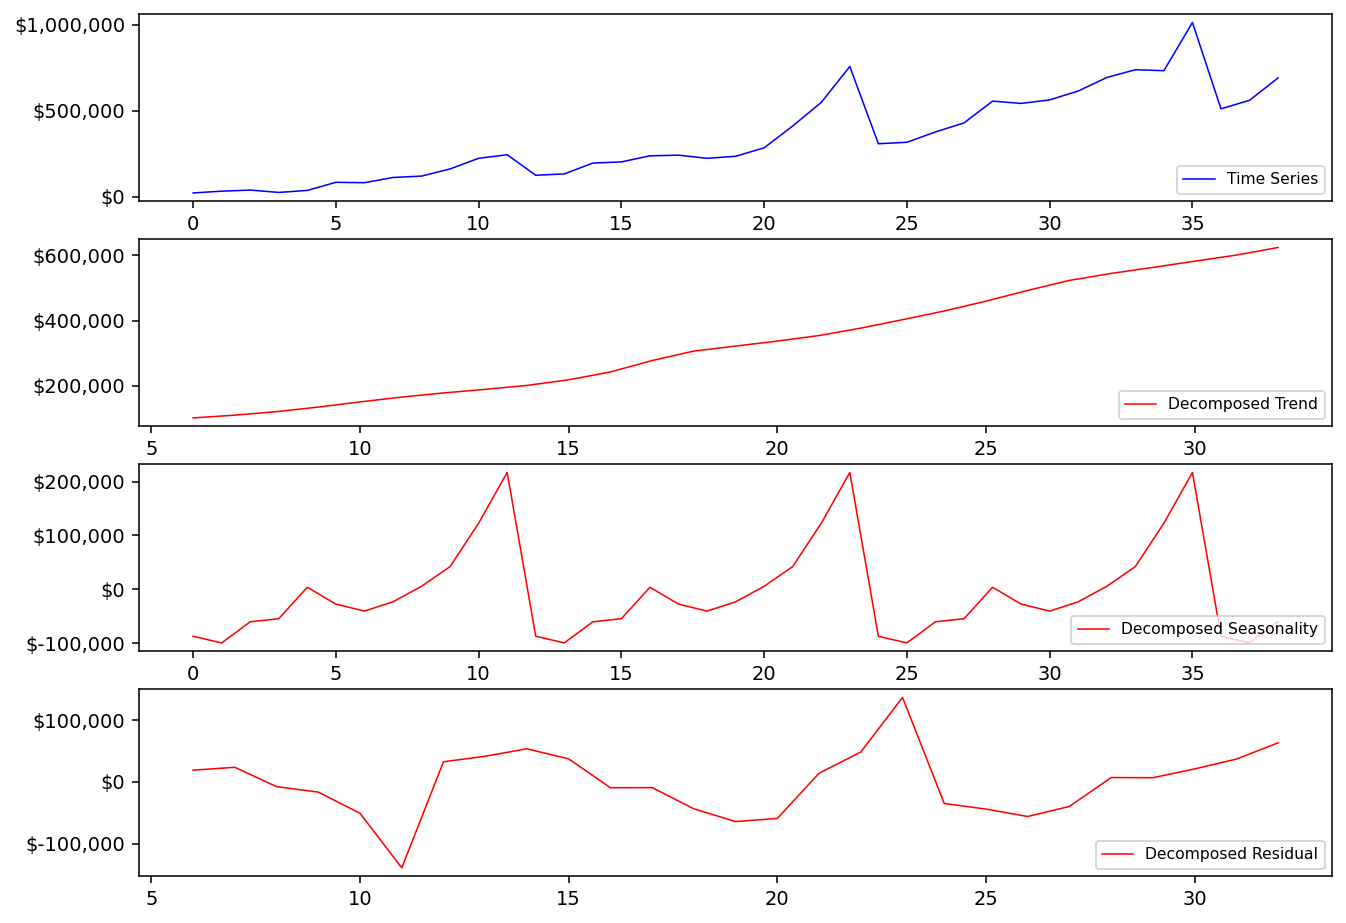

In [8]:
def effects(ax, values, color, label):
    ax.plot(values, color=color, lw=0.8, ms=0, label=label)
    ax.yaxis.set_major_formatter(FuncFormatter(FuncFormatter(lambda y, _: f'${y:,.0f}')))
    ax.legend(loc='lower right', fontsize=8)
    return

fig, axes = plt.subplots(4, 1, figsize=(11,8), dpi=140)
effects(axes[0], sales.values, 'b', 'Time Series')
effects(axes[1], result.trend.values, 'r', 'Decomposed Trend')
effects(axes[2], result.seasonal.values, 'r', 'Decomposed Seasonality')
effects(axes[3], result.resid.values, 'r', 'Decomposed Residual')
plt.show()

**Seasonal Strength**:
   - **F-statistic**: Measures how strong the seasonal component is relative to the residual (error) component. It’s a statistical test from ANOVA that compares the variance in the seasonal component to the variance in the remainder component.
     - When using an F-statistic to evaluate the strength of the seasonal component, the remainder component serves as a baseline for comparison. The F-statistic measures how much of the variation in the data can be attributed to seasonality versus what is left unexplained (the remainder). If the seasonal component explains a large proportion of the variation (relative to the remainder), it indicates a strong, consistent seasonal effect.
   - **Coefficient of Determination (R²)**: Indicates the proportion of variance in the original time series data explained by the seasonal component. A high $R^2$ value suggests a strong and consistent seasonal pattern.

In [9]:
from scipy.stats import f_oneway, linregress
stat, pvalue = f_oneway(result.seasonal, result.resid, nan_policy='omit')
print(f'F-statistics: \n {stat = :0.4f}\n {pvalue = :0.4f}')

coeff_det = linregress(result.seasonal, sales).rvalue
print(f'Coefficient of Determination: \n {coeff_det = :0.4f}')

F-statistics: 
 stat = 0.0755
 pvalue = 0.7844
Coefficient of Determination: 
 coeff_det = 0.4570


**Seasonal Variation Measure**:
- **Seasonal Amplitude**: Calculated as the difference between the maximum and minimum values of the seasonal component, it shows the full range of seasonal fluctuations within a cycle.
- **Standard Deviation of Seasonal Component**: This measures the variability within the seasonal component itself. It’s particularly useful if you want to quantify the spread or dispersion in the seasonal component.

In [10]:
seasonal_amp = np.max(result.seasonal) - np.min(result.seasonal)
print(f'Seasonal Amplitude = {seasonal_amp:,.0f}')
seasonal_std = np.std(result.seasonal)
print(f'St. Dev. Seasonal Component = {seasonal_std:,.0f}')

Seasonal Amplitude = 316,348
St. Dev. Seasonal Component = 86,575


#### 2. Monthly Customer Acquisitions

- **What**: total first-time buyers each month
- **Why**: explains how growth is coming about (new users? existing users? …)
- **How**: sort by customer and transaction date, identify acquisition date for each customer (based on first purchase), and aggregate acquisitions by month

**Analysis**: First purchase of a unique customer ID is used here as a proxy for customer acquisition. Data shows that new customer acquisitions (or initial customer transactions) have trended upwards. Similar to the total monthly sales, the data shows seasonality; with acquisitions in November and December higher than the yearly average.

In [11]:
acquired = df.sort_values(by=['cust_id', 'order_date'])
acquired['initial_purch'] = (~acquired['cust_id'].duplicated()).astype(int)
acquired = acquired.groupby([(acquired.index.year), (acquired.index.month)])['initial_purch'].sum()
acquired.unstack()

order_date,1,2,3,4,5,6,7,8,9,10,11,12
order_date,,,,,,,,,,,,
2016,108.0,129.0,168.0,92.0,161.0,389.0,310.0,525.0,460.0,673.0,796.0,1086.0
2017,395.0,520.0,622.0,625.0,733.0,767.0,699.0,778.0,808.0,809.0,1449.0,2339.0
2018,786.0,819.0,903.0,1166.0,1588.0,1486.0,1499.0,1655.0,1661.0,1455.0,1758.0,2838.0
2019,1126.0,1103.0,1382.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


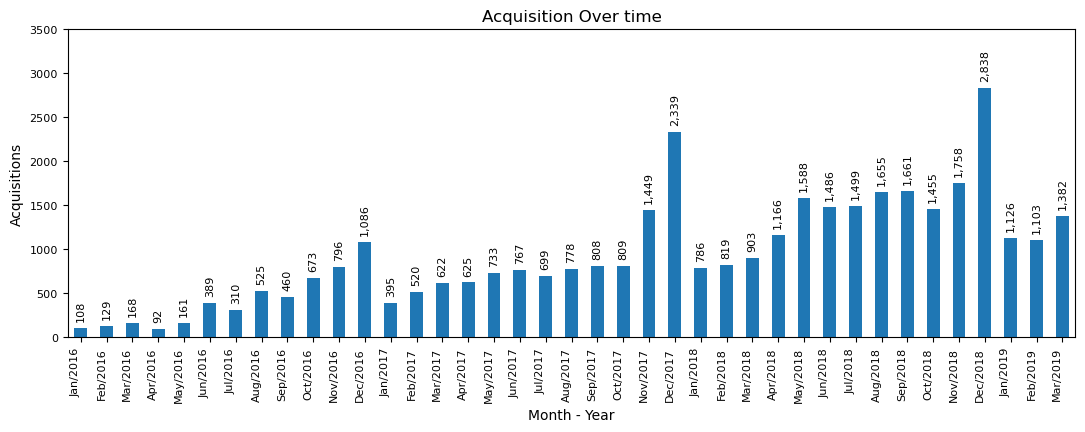

In [12]:
ax = acquired.plot(kind='bar',  
            figsize=(13,4),
            title="Acquisition Over time",
            xlabel='Month - Year',
            ylabel='Acquisitions',
            fontsize=8)

ax.set_xticklabels([f'{pd.Timestamp(year=y, month=m, day=1):%b/%Y}' for y, m in acquired.index], 
                   rotation=90, 
                   ha='right')

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+100, f'{y[i]:,.0f}', ha='center', rotation ='vertical', snap=True, size=8)
        
addlabels(acquired.index, acquired.values)

ax.set_ylim(0, 3500)

plt.show()

#### 3. Customer Acquisition Cost (CAC)

- **What**: amount spent per newly acquired customer over time
- **Why**: Key driver of unit economics (remember, $E(CLV)=E(PAV)-CAC$)
- **How**:

In [13]:
mktg_spend = df_mkt.groupby([(df_mkt.index.year), (df_mkt.index.month)])['total_marketing_spend'].sum()
cac = mktg_spend / acquired